# Optimisation - ou comment ajuster un modèle

Dans ce notebook, nous introduirons différentes méthodes pour résoudre les problèmes d'ajustement d'un modèle à des données.

***Dependencies***
- emcee
- corner
- numpy
- scipy
- matplotlib
- uncertainties

Ce notebook est inspiré d'un cours donné avec Andrew Valentine à ANU-RSES à Canberra, vous trouverez la version originale ici: https://github.com/rses-datascience/DataSurgeries/tree/master/Tutorials/04_Model_Fitting

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

# Générer des données

Pour vraiment travailler sur le problème d'optimisation, nous allons générer des données synthétiques. Nous connaîtrons donc la "vérité" dérrière ces données, nous permettant d'évaluer avec un esprit critique les différentes approches de fit.

Le modèle choisi est une simple fonction polynomiale :

In [4]:
def my_polynomial(x,a,b,c):
    return a + x*b + c*x*x

Nous pouvons utiliser cette fonction pour générer de fausses données

In [5]:
# true parameters
a = 10.0
b = 1.321
c = 0.02978

N = 100

x = np.sort(100*np.random.rand(N))
y = my_polynomial(x,a,b,c)

Les erreurs dans le monde réel sont fréquentes et affectent nos observations. Ici nous allons ajouter des sources d'erreurs aléatoires ET systématiques...


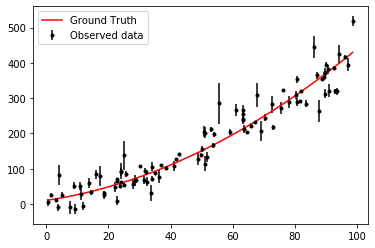

In [6]:
known_ese = np.random.randn(N)*15

f = 2 # our systematic bias coefficient
bias = np.sqrt(y)*f*np.random.randn(N) # the bias is a linear function of a normal distribution centred on x

true_ese = known_ese + bias

y_noisy = y + known_ese + true_ese # this is what we observe

plt.errorbar(x,y_noisy,yerr=known_ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.legend()